# ALeRCE API interaction examples

**WARNING**: This notebook will be replaced by a version using the new database, API and client.

Load libraries

In [1]:
import sys
import requests
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from pandas.io.json import json_normalize
from astropy.time import Time
from datetime import datetime
from IPython.display import HTML

In [2]:
#!pip install alerce
from alerce.api import AlerceAPI

See https://github.com/alercebroker/usecases/blob/master/api/ALeRCE%20ZTF%20DB%20API.md

In [3]:
# continuously load modules (for easier debugging)
%load_ext autoreload
%autoreload 2

# Initialize alerce api object

In [4]:
client = AlerceAPI()

# Classifier taxonomy and numeric mappings

There are two classifiers used in ALeRCE, an early classifier and a late classifier. Each one has its own numeric mappings for the different classes. You can use their string or integer names.

The early classifier uses as input the first detection stamps and contains the following classes:

    "agn"
    "sn"
    "vs"
    "asteroid"
    "bogus"
    
The late classifier uses the light curve information and contains the following classes:

    "sn ia"
    "sn ibc"
    "sn ii"
    "sn iin"
    "slsn"
    "eb/sd/d"
    "eb/c"
    "periodic/other"
    "cv/nova"
    "blazar"
    "agn i"
    "dsct"
    "ceph"
    "lpv"
    "rrl"
    "other"

# 1. query

Query a list of objects

The following json file should be sent

```js
{
total: number, // (if not set the total is counted and the query is slower),
records_per_pages: number. // default 20
page: number (default 1),
sortBy: string columnName, // default nobs
query_parameters:{
    filters:{
        //ZTF Object id
        oid: "ZTFXXXXXX",
        //Number of detections
        nobs: { 
            min: int
            max: int
        },
        //Late Classifier (Random Forest)
        classrf: int,
        pclassrf: float [0-1],
        //Early Classifier (Stamp Classifier)
        classearly: int,
        pclassearly: float [0-1],
    },
    //Coordinate based search (RA,DEC) and Search Radius.
    coordinates:{
        ra: float degrees,
        dec: float degrees,
        sr: float degrees
    },
    dates:{
        //First detection (Discovery date)
        firstmjd: {
         min: float mjd,
         max: float mjd
        }
    }
}
```

### Example: 

Give me all the objects with probability of being SNe greater than 0.3 according to the random forest classifier (light curve based), which have between 2 and 40 detections. Give me the second page, with pages of 10 elements each, of a total of at most 40 objects query result.

Note: probabilities are experimental and should not be fully trusted

In [5]:
total = 40
records_per_page = 10
page = 2
sortBy = "firstmjd"
nobsmin = 10
nobsmax = 40
classrf = "sn ia"
pclassrf = 0.3

params = {
    "total": total,
    "records_per_pages": records_per_page,
    "page": page,
    "sortBy": sortBy,
    "query_parameters": {
        "filters": {
            "nobs": { 
                "min": nobsmin,
                "max": nobsmax
            },
            "classrf": classrf,
            "pclassrf": pclassrf
        }
    }
}

In [6]:
query_results = client.query(params, format='pandas')
query_results.head()

,catalogid,classearly,classrf,classxmatch,deltajd,first_magap_g,first_magap_r,first_magpsf_g,first_magpsf_r,firstmjd,...,nobs,pclassearly,pclassrf,period,sigma_magap_g,sigma_magap_r,sigma_magpsf_g,sigma_magpsf_r,sigmadec,sigmara
oid,,,,,,,,,,,,,,,,,,,,,
ZTF20aboprop,None,18,10,None,7.009606,21.218000,20.677099,21.220800,20.822399,59053.373461,...,10,0.343094,0.316920,None,0.401156,0.270273,0.377059,0.346789,0.000045,0.000046
ZTF20abobcon,None,19,10,None,12.956412,20.798100,19.858801,20.836905,19.947433,59053.350579,...,13,0.689525,0.364032,None,0.710617,0.187579,0.518684,0.218847,0.000036,0.000064
ZTF20abobpcb,None,19,10,None,13.012431,20.027901,19.989000,20.150982,20.507500,59053.332049,...,15,0.354716,0.307776,None,0.386303,0.351759,0.438840,0.475548,0.000028,0.000058
ZTF20abonvte,None,19,10,None,12.997998,20.091200,20.675699,19.845469,20.759300,59053.306667,...,14,0.616483,0.361296,None,0.599097,0.597059,0.455294,0.604295,0.000029,0.000049
ZTF20abnvbzq,None,19,10,None,14.051667,20.423599,20.635300,20.160856,20.410513,59052.434850,...,10,0.459879,0.376992,None,0.713268,0.613953,0.505661,0.501343,0.000021,0.000041


### Example: 

Give me the last 100 objects with classified as SNe according to the early classifier (one image stamp)

Note: this is experimental, about 90% of the candidates are false positives

In [7]:
mjd_48hr = Time(datetime.utcnow(), scale='utc').mjd - 2.

total = 100
records_per_page = 100
sortBy = "pclassearly"
classearly = 'sn'

params = {
    "total": total,
    "records_per_pages": records_per_page,
    "sortBy": sortBy,
    "query_parameters": {
        "filters": {
            "classearly": classearly
        },
        "dates": {
            "firstmjd": {
                "min": mjd_48hr
            }
        }
    }
}

In [8]:
query_results = client.query(params, format='pandas')
query_results.head()

,catalogid,classearly,classrf,classxmatch,deltajd,first_magap_g,first_magap_r,first_magpsf_g,first_magpsf_r,firstmjd,...,nobs,pclassearly,pclassrf,period,sigma_magap_g,sigma_magap_r,sigma_magpsf_g,sigma_magpsf_r,sigmadec,sigmara
oid,,,,,,,,,,,,,,,,,,,,,
ZTF19abyvcsp,None,20,None,None,0.0,None,14.1918,None,14.2153,59065.317917,...,1,0.743372,None,None,None,None,None,None,None,None
ZTF20aahhmgq,None,20,None,None,0.0,None,14.2984,None,14.3113,59065.318380,...,1,0.716618,None,None,None,None,None,None,None,None
ZTF19aaetbgh,None,20,None,None,0.0,None,14.0538,None,14.0657,59065.318380,...,1,0.713971,None,None,None,None,None,None,None,None
ZTF20abhzmkz,None,20,None,None,0.0,None,14.3202,None,14.3592,59065.380856,...,1,0.687644,None,None,None,None,None,None,None,None
ZTF19aadzggx,None,20,None,None,0.0,None,15.065,None,15.0616,59065.318380,...,1,0.686464,None,None,None,None,None,None,None,None


(19.039136206193472, 12.181513950719642)

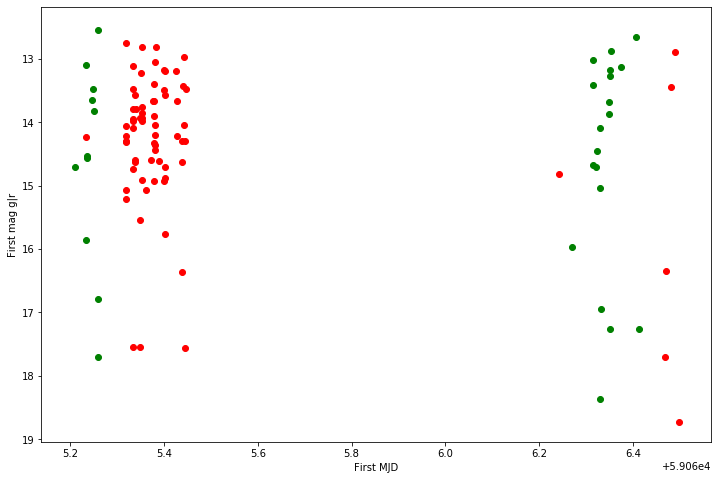

In [9]:
# Show first mag vs first MJD
fig, ax = plt.subplots(figsize = (12, 8))
mask = query_results.first_magpsf_r.notnull()
ax.scatter(query_results.firstmjd[mask], query_results.first_magpsf_r[mask], c = 'r')
mask = query_results.first_magpsf_g.notnull()
ax.scatter(query_results.firstmjd[mask], query_results.first_magpsf_g[mask], c = 'g')
ax.set_xlabel("First MJD")
ax.set_ylabel("First mag g|r")
ax.set_ylim(ax.get_ylim()[::-1])

You can see the ZTF filter changes during the night. The missing times are due to the ZTF private stream.

# 2. get_sql

Get the sql query using the same parameters as the previous query

In [10]:
client.get_sql(params)

'SELECT * FROM objects WHERE classearly=20 AND  firstmjd >= 59065.08989432678 AND firstmjd IS NOT NULL'

# 3. get_detections

Get all the detections for an object

In [11]:
oid = "ZTF19abueupg"

In [12]:
detections = client.get_detections(oid, format='pandas')
display(detections.head())
", ".join(list(detections))

,candid_str,dec,diffmaglim,distpsnr1,fid,field,has_stamps,isdiffpos,magap,magap_corr,...,rb,rcid,sgscore1,sigmadec,sigmagap,sigmagap_corr,sigmagnr,sigmapsf,sigmapsf_corr,sigmara
candid,,,,,,,,,,,,,,,,,,,,,
970313001115015006,970313001115015006,51.382551,20.446541,5.113520,1,797,None,1,19.706900,19.706900,...,0.920000,11,0.5,0.09,0.1900,0.1900,0.085,0.139590,0.139590,0.09
971263501115015039,971263501115015039,51.382555,20.572720,5.004293,2,797,None,1,19.548800,19.548800,...,0.592857,11,0.5,0.09,0.1692,0.1692,0.130,0.155431,0.155431,0.09
971289301115015006,971289301115015006,51.382573,20.407963,5.065497,1,797,None,1,19.450300,19.450300,...,0.877143,11,0.5,0.09,0.1279,0.1279,0.085,0.099974,0.099974,0.09
972264951115015027,972264951115015027,51.382526,20.445602,5.038084,2,797,None,1,18.945101,18.945101,...,0.934286,11,0.5,0.09,0.1063,0.1063,0.130,0.093884,0.093884,0.09
972290601115015008,972290601115015008,51.382546,20.350231,5.046748,1,797,None,1,19.068300,19.068300,...,0.951429,11,0.5,0.09,0.1081,0.1081,0.085,0.096079,0.096079,0.09


'candid_str, dec, diffmaglim, distpsnr1, fid, field, has_stamps, isdiffpos, magap, magap_corr, magnr, magpsf, magpsf_corr, mjd, oid, parent_candid, ra, rb, rcid, sgscore1, sigmadec, sigmagap, sigmagap_corr, sigmagnr, sigmapsf, sigmapsf_corr, sigmara'

# 4. get_non_detections

In [13]:
non_detections = client.get_non_detections(oid, format='pandas')
non_detections.head()

,diffmaglim,fid,oid
mjd,,,
58695.278808,18.942801,2,ZTF19abueupg
58695.308171,20.085800,1,ZTF19abueupg
58696.280255,20.712299,2,ZTF19abueupg
58696.309468,20.865499,1,ZTF19abueupg
58697.302245,20.648100,2,ZTF19abueupg


(21.146429470638658, 15.147695824403677)

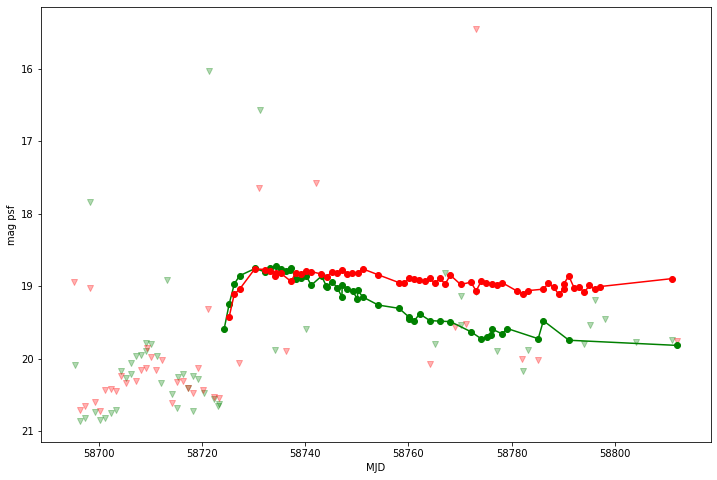

In [14]:
fig, ax = plt.subplots(figsize = (12, 8))
colors = ["g", "r"]
for fid in [1, 2]:
    mask = detections.fid == fid
    ax.plot(detections.mjd[mask], detections.magpsf[mask], c = colors[fid - 1], marker = "o")
    mask = non_detections.fid == fid
    # note that the index of non-detectionsis the mjd
    ax.scatter(non_detections.index[mask], non_detections.diffmaglim[mask], c = colors[fid - 1], marker = "v", alpha=0.3)
ax.set_xlabel("MJD")
ax.set_ylabel("mag psf")
ax.set_ylim(ax.get_ylim()[::-1])

# 5. get_stats

In [15]:
stats = client.get_stats(oid, format='pandas')
display(stats)
stats.keys()

oid                ZTF19abueupg
nobs                        108
mean_magap_g             19.208
mean_magap_r            18.9237
median_magap_g          19.1557
median_magap_r          18.8744
max_magap_g             20.2068
max_magap_r             19.5804
min_magap_g             18.5337
min_magap_r             18.6207
sigma_magap_g          0.401947
sigma_magap_r          0.222362
last_magap_g            19.7405
last_magap_r            18.9057
first_magap_g           19.7069
first_magap_r           19.5488
mean_magpsf_g           19.2064
mean_magpsf_r           18.9317
median_magpsf_g         19.1487
median_magpsf_r         18.9337
max_magpsf_g            19.8168
max_magpsf_r            19.4284
min_magpsf_g            18.7283
min_magpsf_r            18.7589
sigma_magpsf_g         0.344163
sigma_magpsf_r         0.118769
last_magpsf_g           19.8168
last_magpsf_r           18.8953
first_magpsf_g          19.5887
first_magpsf_r          19.4284
meanra                  267.803
meandec 

Index(['oid', 'nobs', 'mean_magap_g', 'mean_magap_r', 'median_magap_g',
       'median_magap_r', 'max_magap_g', 'max_magap_r', 'min_magap_g',
       'min_magap_r', 'sigma_magap_g', 'sigma_magap_r', 'last_magap_g',
       'last_magap_r', 'first_magap_g', 'first_magap_r', 'mean_magpsf_g',
       'mean_magpsf_r', 'median_magpsf_g', 'median_magpsf_r', 'max_magpsf_g',
       'max_magpsf_r', 'min_magpsf_g', 'min_magpsf_r', 'sigma_magpsf_g',
       'sigma_magpsf_r', 'last_magpsf_g', 'last_magpsf_r', 'first_magpsf_g',
       'first_magpsf_r', 'meanra', 'meandec', 'sigmara', 'sigmadec', 'deltajd',
       'lastmjd', 'firstmjd', 'period', 'catalogid', 'classxmatch', 'classrf',
       'pclassrf', 'pclassearly', 'classearly'],
      dtype='object')

# 6. get_features

In [17]:
features = client.get_features(oid, format='pandas')
features

n_samples_1                                 46
Amplitude_1                           0.500953
AndersonDarling_1                     0.999878
Autocor_length_1                             9
Beyond1Std_1                          0.347826
Con_1                                        0
Eta_e_1                              0.0822985
Gskew_1                                0.21965
MaxSlope_1                             3.38831
Meanvariance_1                       0.0178182
MedianAbsDev_1                        0.313098
MedianBRP_1                           0.152174
PairSlopeTrend_1                      0.433333
PercentAmplitude_1                   0.0348891
Q31_1                                 0.578411
PeriodLS_v2_1                          1.00766
Period_fit_v2_1                              0
Psi_CS_v2_1                           0.281475
Psi_eta_v2_1                           0.36816
Rcs_1                                 0.448765
Skew_1                                0.201482
SmallKurtosis

# 7. get_stamp

Get the stamps of an object.

See https://github.com/alercebroker/usecases/blob/master/api/ALeRCE%20AVRO-STAMP%20Access%20API.md

In [18]:
# note that the index of detections is the candid
print(oid)
client.plot_stamp(oid)
client.plot_stamp(oid, detections.index.min())
client.plot_stamp(oid, detections.index.max())

ZTF19abueupg
